In [14]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


In [3]:

def eda_report(analyzed_dataset):
    """
    Проведение EDA-анализа над переданным датасетом
    """
    """Вывод статистики по дата фрейму"""
    print('***---- head  ------***')
    print(analyzed_dataset.head())
    print('***---- shape  ------***')
    print(analyzed_dataset.shape)
    print('***---- describe  ------***')
    print(analyzed_dataset.describe())
    print('***---- нулевые значения  ------***')
    print(analyzed_dataset.isnull().sum())
    print('***---- Анализ атрибутов  ------***')
    for col in analyzed_dataset.columns:
        print(f'проводим разбор по атрибуту {col}')
        print(f'тип данных: {analyzed_dataset[col].dtypes}')
        print(f'гранулярность данных {analyzed_dataset[col].nunique()}')
        print('Частота появления каждого значения:')
        print(analyzed_dataset[col].value_counts())

In [4]:

def show_metrics(model_name, y_test, y_pred):
    """
    Отображение метрик для модели
    """
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'\n*****************')
    print(f'Метрики качества   метода {model_name}:')
    print(f'*****************')
    print(f'MAE: {mae:.4f}')
    print(f'MSE: {mse:.4f}')
    print(f'R²: {r2:.4f}')

In [5]:

def preprocessing_input_data(dataset):
    """
    Предобработка датасета:
        просмотр статистики и определение актуальных параметров
    """
    eda_report(dataset)

    # последовательное преобрабование даты переписи из строки в дату а затем в число
    dataset['Reference Date'] = dataset['Reference Date'].str.replace("0 December", "1 December")
    dataset['Reference Date'] = pd.to_datetime(dataset['Reference Date'])
    dataset['Reference Date'] = dataset['Reference Date'].astype('int64')

    # отбор данных без разбивки по полу
    dataset = dataset[dataset['Sex Code'] == 0]
    # определение актуальных столбцов
    data = dataset[["Country or Area Code", "Reference Date", "Code of City", "Code of City type"]]
    # определение целевой функции
    target = dataset["Value"]
    # возвращаем значения
    return data, target

In [6]:

def show_diagrams(model_name, dataset, y_test, y_pred, model):
    """
    Визуализация результатов на графиках
    """

    # Формируем фрейм для отображения результатов
    results = pd.DataFrame({
        'ID': dataset.loc[y_test.index, 'ID'].values,
        'Actual': y_test.values,
        'Predicted': y_pred
    }).sort_values('ID').reset_index(drop=True)

    # Графиков много не бывает
    # Scatter plot с линией y=x
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x='Actual', y='Predicted', data=results, alpha=0.6)
    plt.plot([results['Actual'].min(), results['Actual'].max()],
             [results['Actual'].min(), results['Actual'].max()],
             color='red', linestyle='--', label='y = x')
    plt.xlabel('Фактические значения "Численность населения"')
    plt.ylabel('Предсказанные значения "Численность населения"')
    plt.title(f'Фактические vs Предсказанные значения для модели {model_name}')
    plt.legend()
    plt.show()

    # Линейный график для последовательности наблюдений
    plt.figure(figsize=(14, 6))
    plt.plot(results['ID'], results['Actual'], label='Фактические значения', color='blue')
    plt.plot(results['ID'], results['Predicted'], label='Предсказанные значения', color='red', alpha=0.7)
    plt.xlabel('ID (Порядковый номер наблюдения)')
    plt.ylabel('Global_active_power')
    plt.title(f'Фактические и Предсказанные значения для модели {model_name}')
    plt.legend()
    plt.show()

    # Распределение ошибок предсказания
    results['Error'] = results['Actual'] - results['Predicted']
    plt.figure(figsize=(10, 6))
    sns.histplot(results['Error'], bins=50, kde=True, color='purple')
    plt.xlabel('Ошибка (Фактические - Предсказанные)')
    plt.title(f'Распределение ошибок предсказания для модели {model_name}')
    plt.show()

    # Боксплот ошибок
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=results['Error'], color='lightgreen')
    plt.xlabel('Ошибка (Фактические - Предсказанные)')
    plt.title(f'Боксплот ошибок предсказания для модели {model_name}')
    plt.show()

    # Корреляционная матрица между фактическими и предсказанными значениями
    plt.figure(figsize=(6, 4))
    corr = results[['Actual', 'Predicted']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=0, vmax=1)
    plt.title(f'Корреляция между фактическими и предсказанными значениями для модели {model_name}')
    plt.show()

    #  Важность признаков
    if model:
        feature_names = ["Country or Area Code", "Reference Date", "Code of City", "Code of City type"]
        feature_importances = pd.Series(model.feature_importances_, index=feature_names)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=feature_importances.values, y=feature_importances.index, color='skyblue')
        plt.xlabel('Важность признака')
        plt.ylabel('Признак')
        plt.title(f'Важности признаков в модели {model_name}')
        plt.show()

        # График 6: Анализ остатков
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=results['Error'], alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Остатки (Фактические - Предсказанные)')
    plt.title(f'Анализ остатков для модели {model_name}')
    plt.show()

In [11]:
    file_name = 'data/UNdata_Export_20241025_142506414.txt'
    dataset = pd.read_csv(file_name, sep=';')

In [12]:
   data, target = preprocessing_input_data(dataset)

***---- head  ------***
   Country or Area Code Country or Area  Year Reference Date  Area Code  \
0                   248   Åland Islands  2023    1 July 2023          0   
1                   248   Åland Islands  2023    1 July 2023          0   
2                   248   Åland Islands  2023    1 July 2023          0   
3                   248   Åland Islands  2022    1 July 2022          0   
4                   248   Åland Islands  2022    1 July 2022          0   

    Area  Sex Code         Sex  Code of City       City  Code of City type  \
0  Total         0  Both Sexes         14900  MARIEHAMN                  1   
1  Total         1        Male         14900  MARIEHAMN                  1   
2  Total         2      Female         14900  MARIEHAMN                  1   
3  Total         0  Both Sexes         14900  MARIEHAMN                  1   
4  Total         1        Male         14900  MARIEHAMN                  1   

     City type  Record Type Code         Record Type  Re

In [15]:
    X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size=0.2, random_state=13)

In [17]:
model1 = LinearRegression()
model1_name = 'Линейная регрессия'
model1.fit(X_train, Y_train)
    # Предсказание на тестовой выборке
y_pred_linear = model1.predict(X_test)
    # показываю метрики
show_metrics(model1_name, Y_test, y_pred_linear)


*****************
Метрики качества   метода Линейная регрессия:
*****************
MAE: 394111.8626
MSE: 981260861486.0969
R²: 0.0035


In [18]:
    model2 =RandomForestRegressor()
    model2_name = 'Метод случайного леса'
    model2.fit(X_train, Y_train)
    # Предсказание на тестовой выборке
    y_pred_random_forest = model2.predict(X_test)
    # показываю метрики
    show_metrics(model2_name, Y_test, y_pred_random_forest)


*****************
Метрики качества   метода Метод случайного леса:
*****************
MAE: 132135.9086
MSE: 335143009353.1160
R²: 0.6597


In [20]:
    model3 = GradientBoostingRegressor()
    model3_name = 'Градиентный бустинг'
    model3.fit(X_train, Y_train)

    # Предсказание на тестовой выборке
    y_pred_boost = model3.predict(X_test)
    # показываю метрики
    show_metrics(model3_name, Y_test, y_pred_boost)


*****************
Метрики качества   метода Градиентный бустинг:
*****************
MAE: 326550.3777
MSE: 623167117706.4861
R²: 0.3672


In [21]:
    #  Для удобства визуализации доббавим автоинкрементный столбец
    dataset.insert(0, 'ID', range(0, len(dataset)))

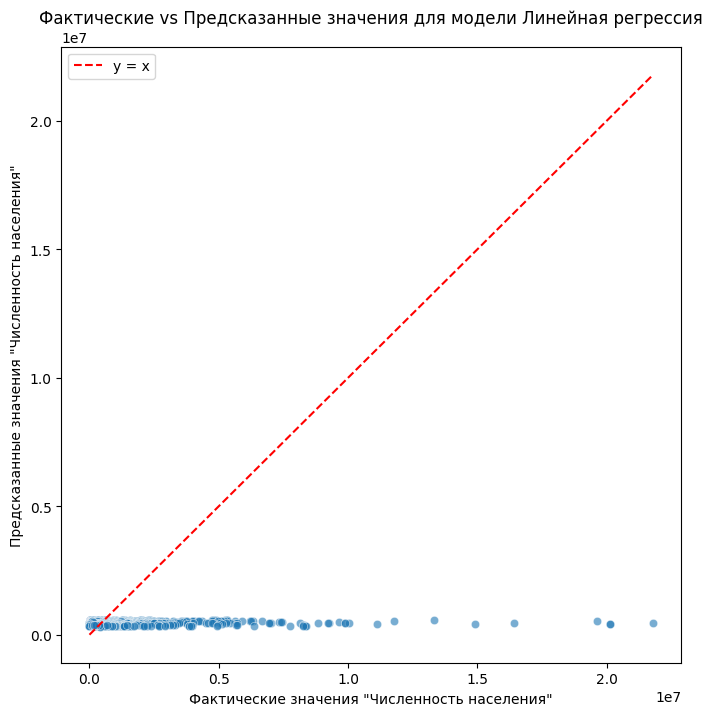

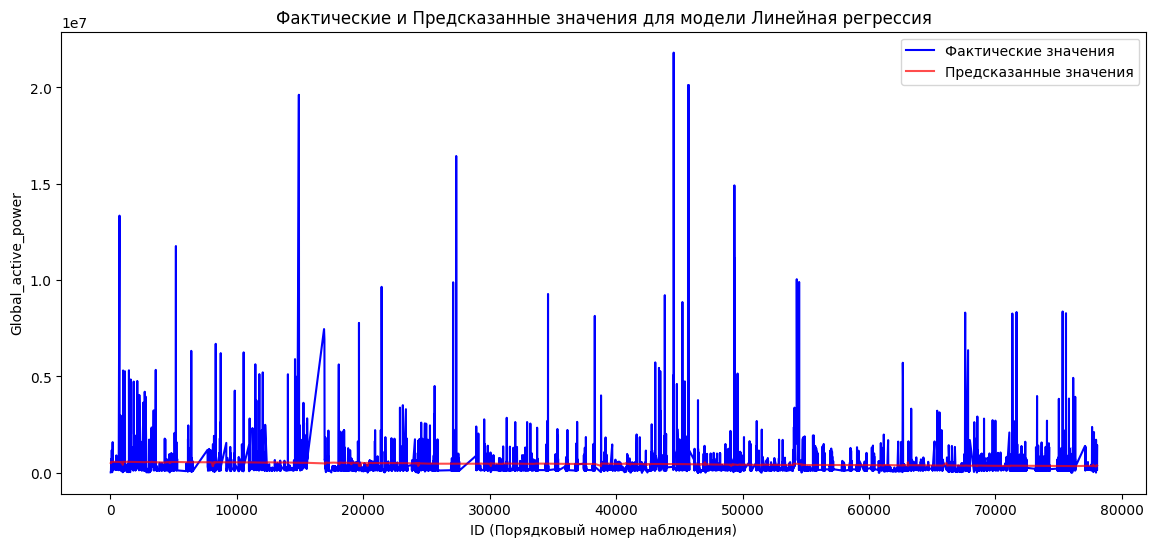

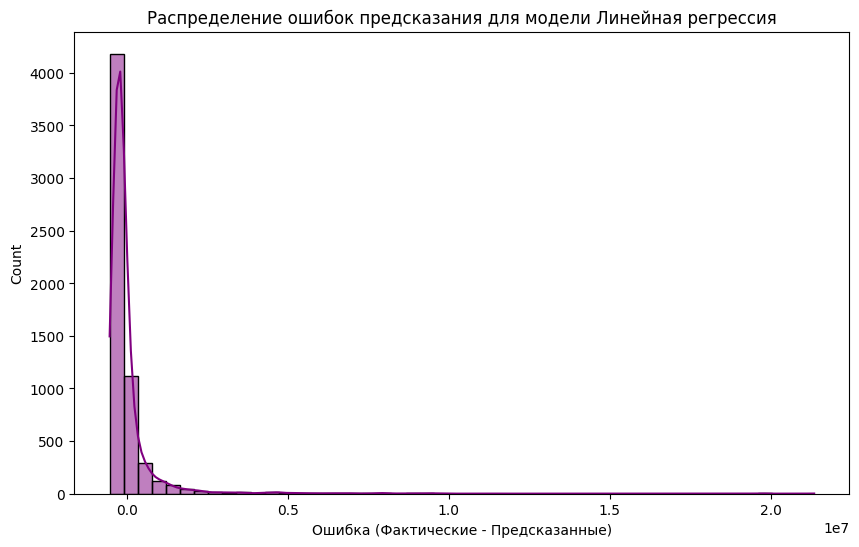

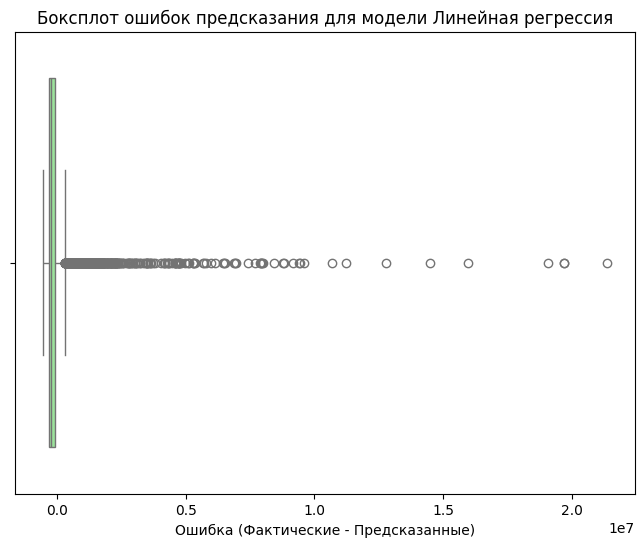

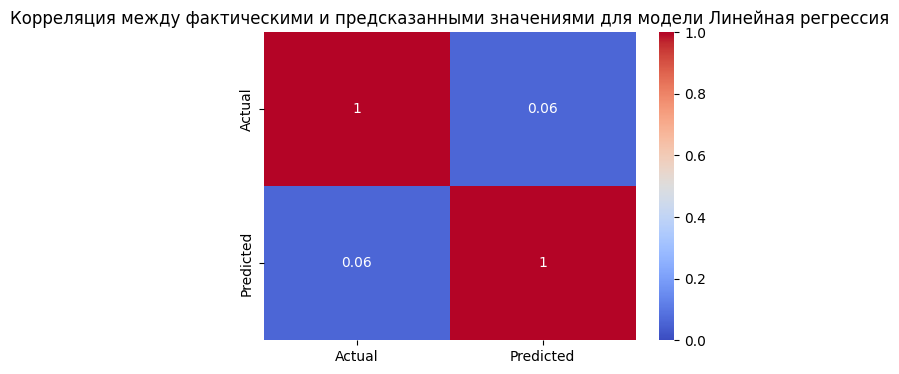

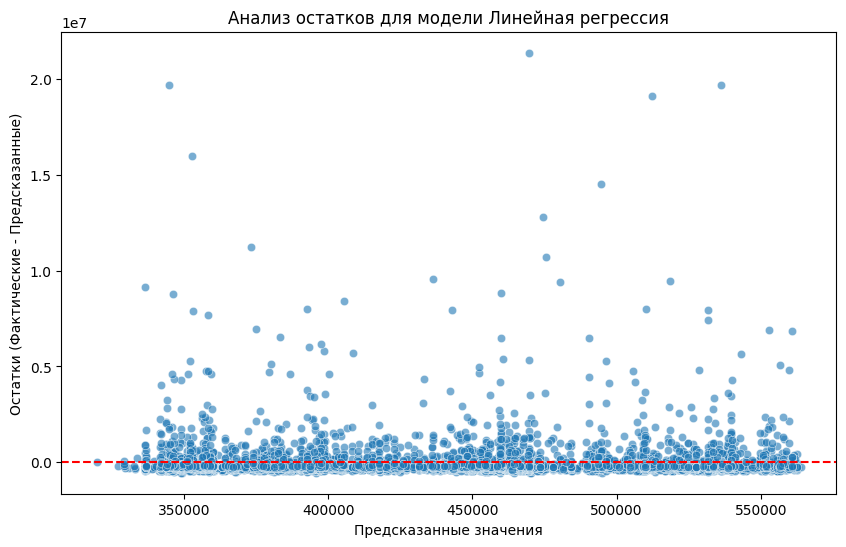

In [22]:
  show_diagrams(model1_name, dataset, Y_test, y_pred_linear, None)

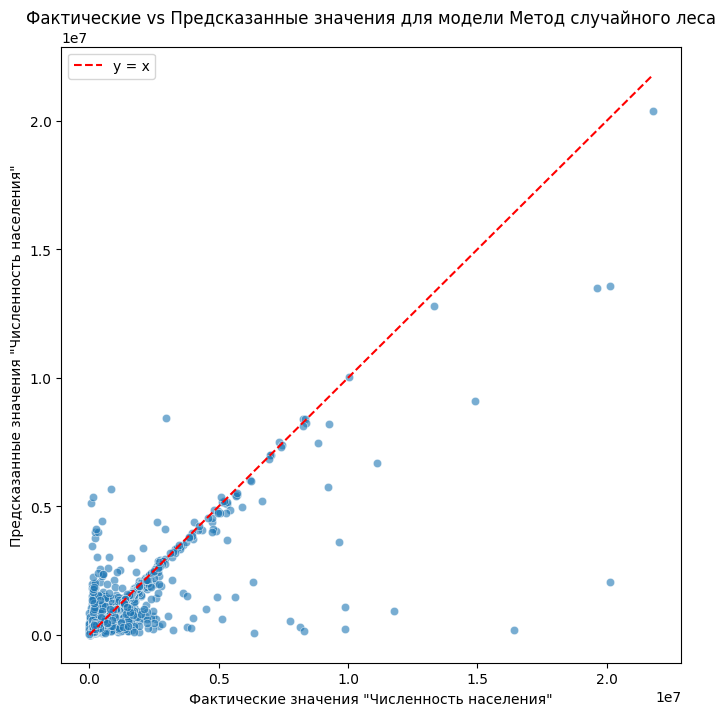

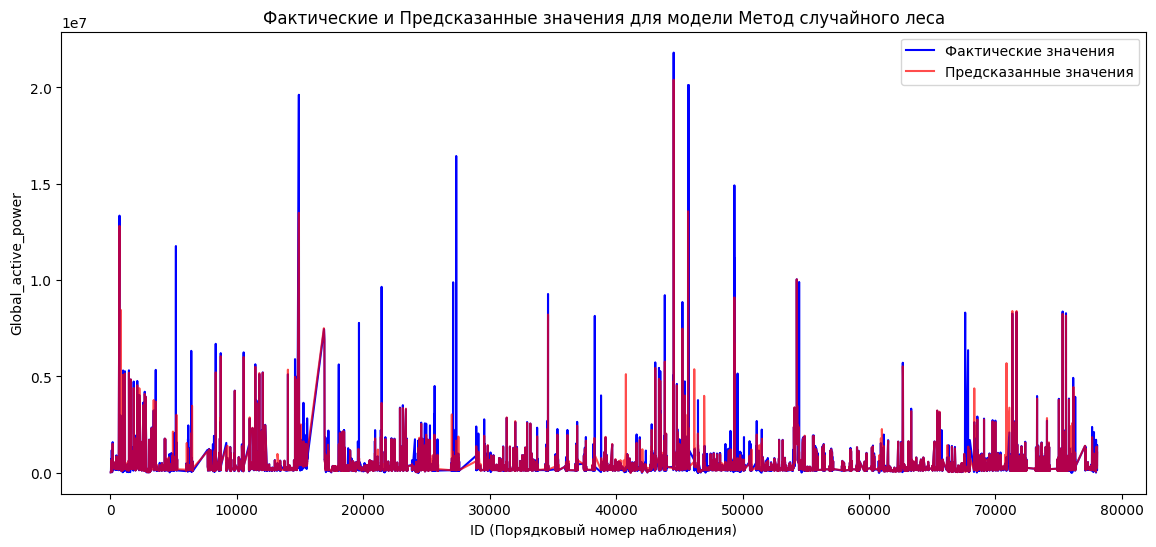

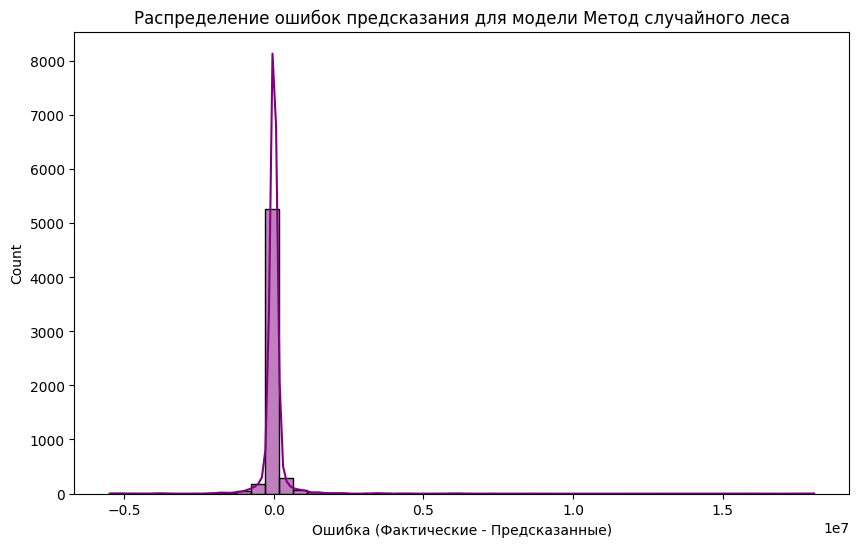

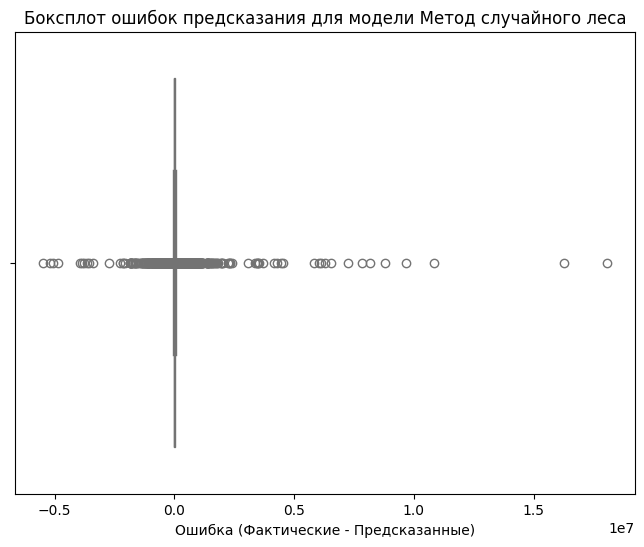

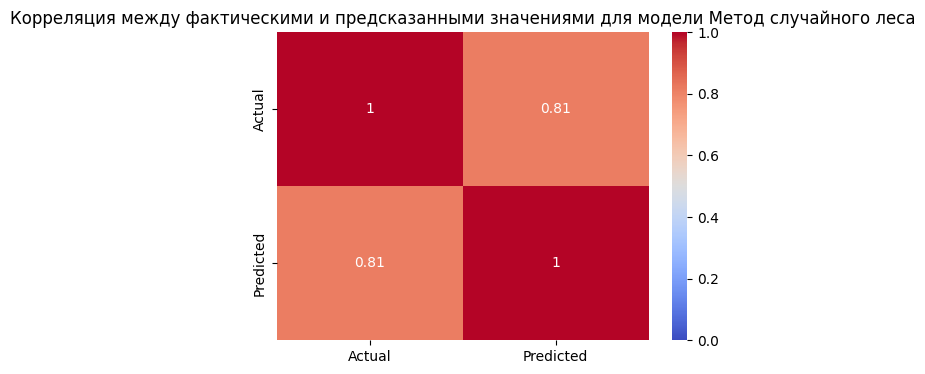

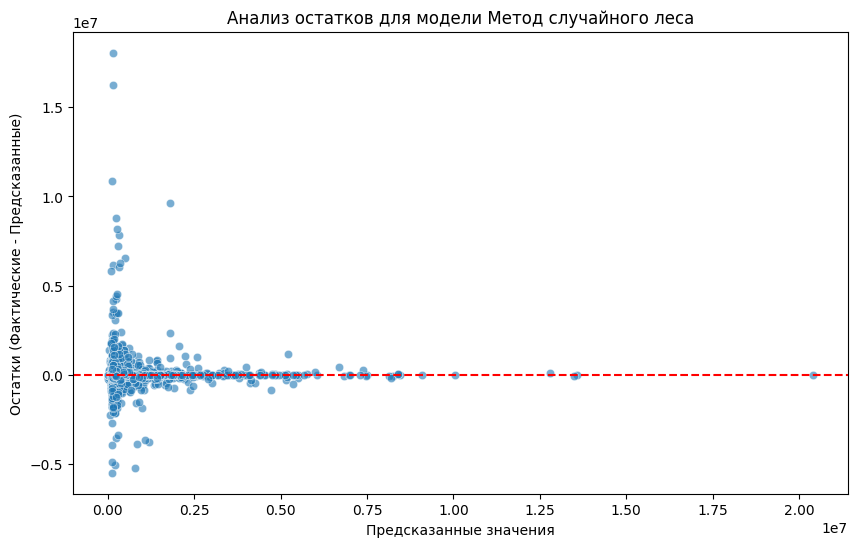

In [23]:
 show_diagrams(model2_name, dataset, Y_test, y_pred_random_forest, None)

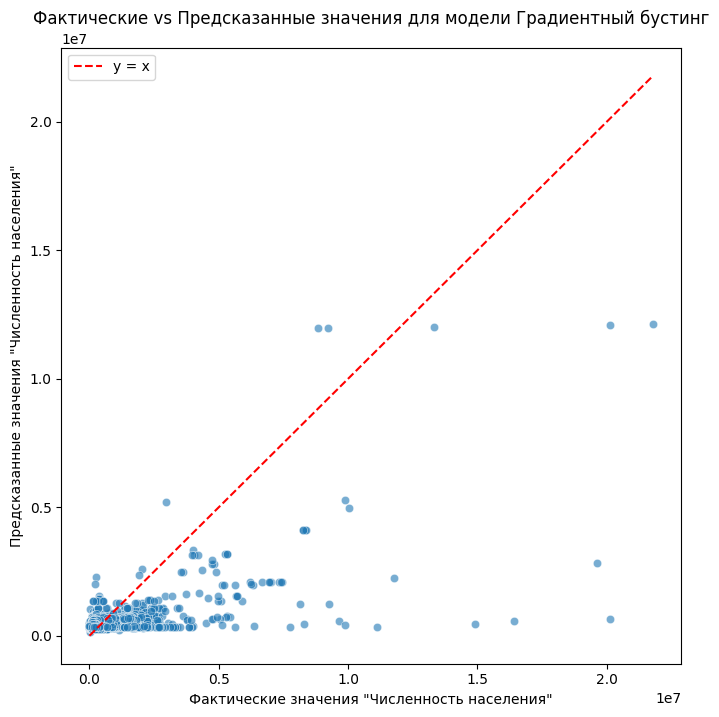

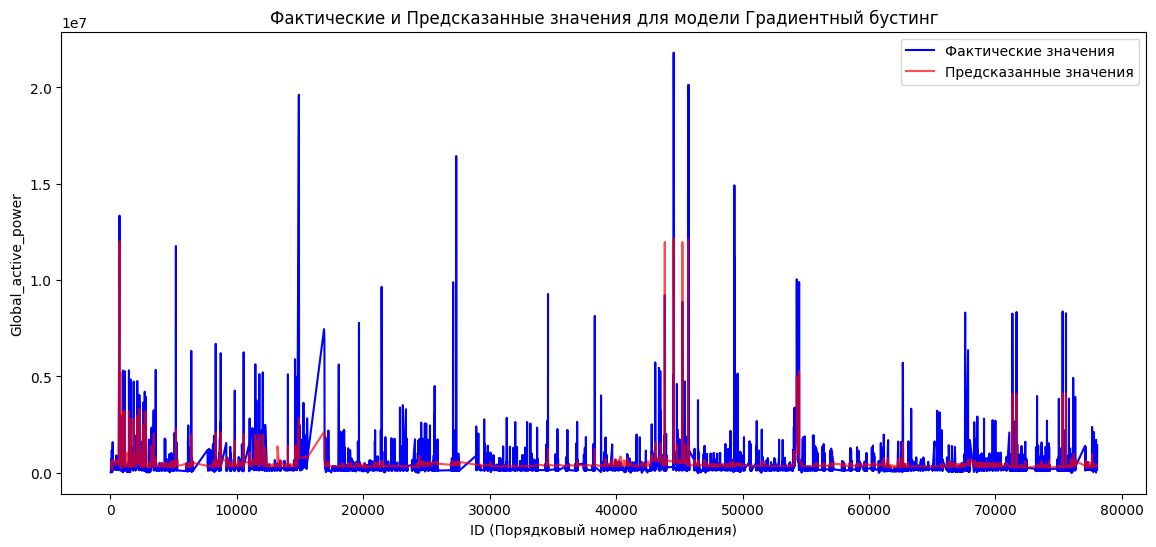

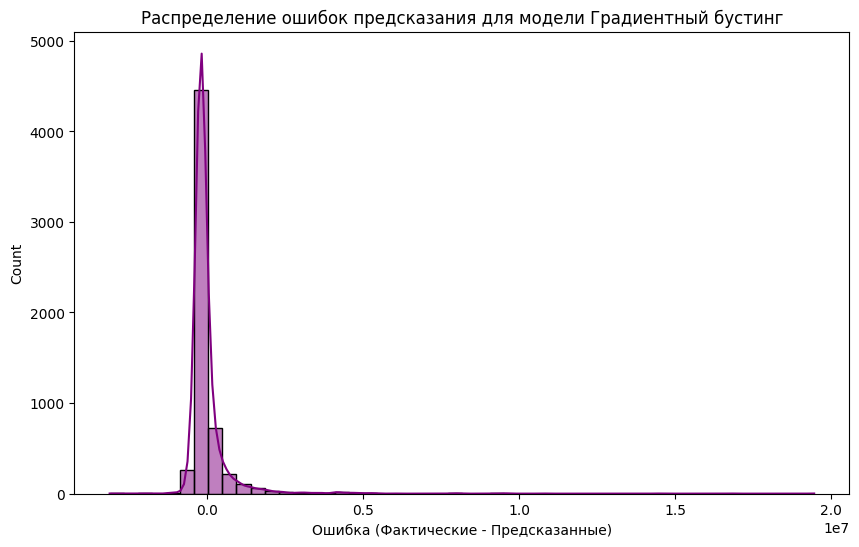

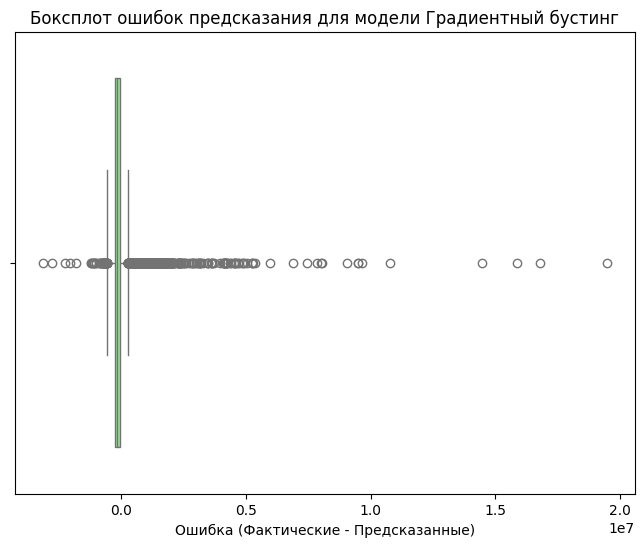

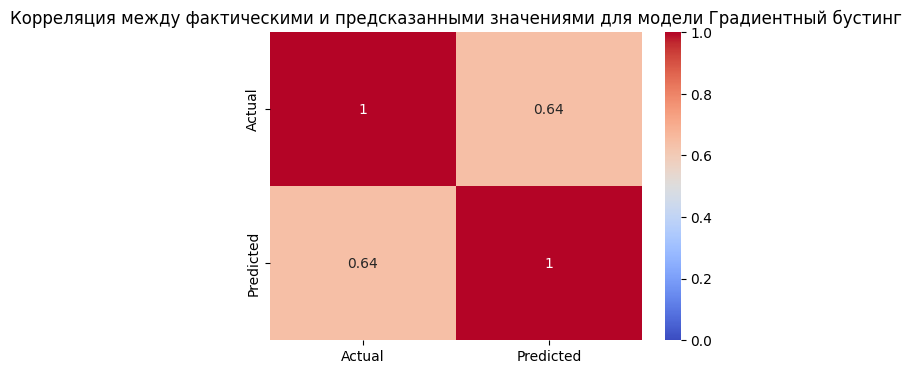

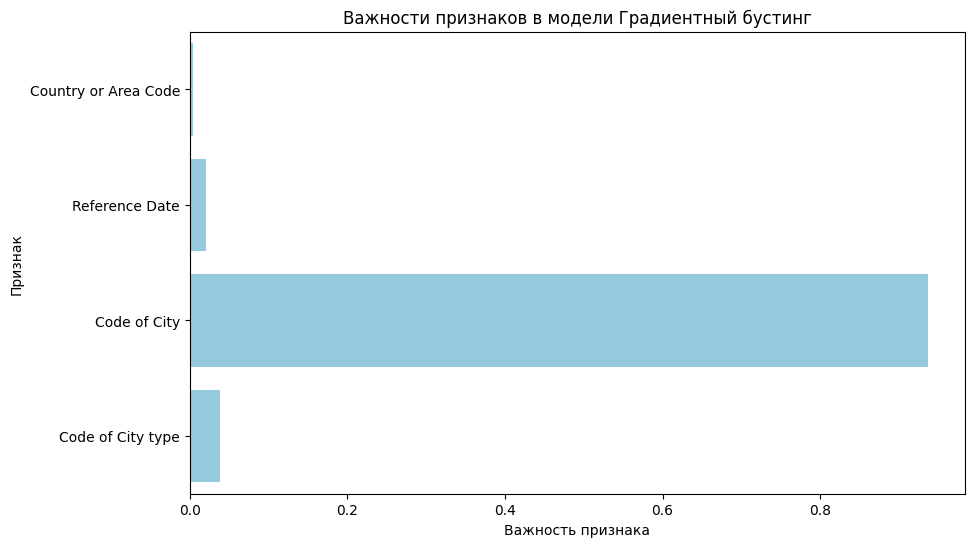

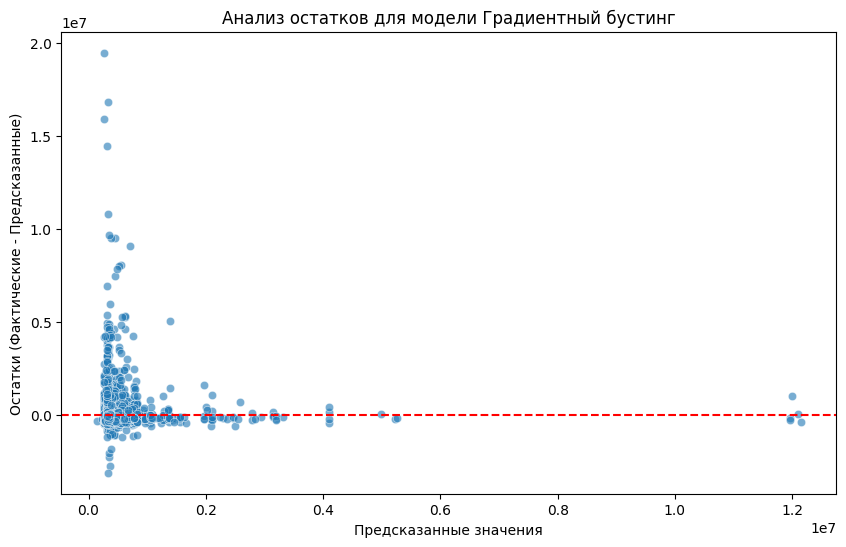

In [24]:
show_diagrams(model3_name, dataset, Y_test, y_pred_boost, model3)